In [1]:
from collections import Counter

import numpy as np
from numpy import genfromtxt
import scipy.io
from scipy.stats import mode
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score
from pydot import graph_from_dot_data
import io
import random
import pandas as pd
import matplotlib.pyplot as plt


# Dataset
spam = scipy.io.loadmat('datasets/spam_data/spam_data.mat')
spam_training_data, spam_training_labels = spam['training_data'], np.squeeze(spam['training_labels'])
spam_test = spam['test_data']

# Preprocess for titanic data
def preprocess(data, fill_mode=True, min_freq=10, onehot_cols=[]):
    # fill_mode = False

    # Temporarily assign -1 to missing data
    data[data == b''] = '-1'
    
    # Hash the columns (used for handling strings)
    onehot_encoding = []
    onehot_features = []
    for col in onehot_cols:
        counter = Counter(data[:, col])
        for term in counter.most_common():
            if term[0] == b'-1':
                continue
            if term[-1] <= min_freq:
                break
            onehot_features.append(term[0])
            onehot_encoding.append((data[:, col] == term[0]).astype(float))
        data[:, col] = '0'
    onehot_encoding = np.array(onehot_encoding).T
    data = np.hstack(
        [np.array(data, dtype=float),
         np.array(onehot_encoding)])
    # Replace missing data with the mode value.
    if fill_mode:
        # TODO
        for col in range(data.shape[1]):
            missing_idx = (data[:, col] == -1)
            if missing_idx.any():
                col_mode = mode(data[~missing_idx, col])[0]
                data[missing_idx, col] = col_mode

    return data, onehot_features


# Load titanic data
data = genfromtxt('datasets/titanic/titanic_training.csv', delimiter=',', dtype=None)
test_data = genfromtxt('datasets/titanic/titanic_testing_data.csv', delimiter=',', dtype=None)
y = data[1:, 0]  # label = survived
class_names = ["Died", "Survived"]

labeled_idx = np.where(y != b'')[0]
y = np.array(y[labeled_idx], dtype=float).astype(int)
print("Preprocessing the titanic dataset")
X, onehot_features = preprocess(data[1:, 1:], onehot_cols=[1, 5, 7, 8])  # onehot_cols: [pclass, parch, fare, cabin]
X = X[labeled_idx, :]
Z, _ = preprocess(test_data[1:, :], onehot_cols=[1, 5, 7, 8])
assert X.shape[1] == Z.shape[1]
titanic_features = list(data[0, 1:]) + onehot_features
titanic_features = [feature.decode('utf-8') for feature in titanic_features]

# Rename titanic data
titanic_training, titanic_training_labels = X, y
titanic_test = Z

Preprocessing the titanic dataset


/var/folders/3j/yt011p3d543_vhy83qz20ctc0000gr/T/ipykernel_41502/136115917.py:59: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data = genfromtxt('datasets/titanic/titanic_training.csv', delimiter=',', dtype=None)
/var/folders/3j/yt011p3d543_vhy83qz20ctc0000gr/T/ipykernel_41502/136115917.py:60: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  test_data = genfromtxt('datasets/titanic/titanic_testing_data.csv', delimiter=',', dtype=None)


In [2]:
# Helper func
def evaluate(clf):
    print("Cross validation", cross_val_score(clf, X, y))
    if hasattr(clf, "decision_trees"):
        counter = Counter([t.tree_.feature[0] for t in clf.decision_trees])
        first_splits = [
            (features[term[0]], term[1]) for term in counter.most_common()
        ]
        print("First splits", first_splits)

def evaluate_simple(pred, y):
    return np.mean(pred == y)

def train_valid_split(X, y, holdout):
    num = X.shape[0]
    split = int(num * holdout)
    X_train, X_valid = X[:split], X[split:]
    y_train, y_valid = y[:split], y[split:]    
    return X_train, X_valid, y_train, y_valid

def results_to_csv(y_test, name, method):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1 # Ensures that the index starts at 1
    df.to_csv(f'{name}_{method}_pred.csv', index_label='Id')

### Decision Tree

In [3]:
class DecisionTree:
    def __init__(self, max_depth=3, feature_labels=None):
        self.max_depth = max_depth
        self.features = feature_labels
        self.left, self.right = None, None  # for non-leaf nodes
        self.split_idx, self.thresh = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes
        
    @staticmethod
    def entropy(y):
        # TODO
        _, counts = np.unique(y, return_counts=True)
        prob = counts / counts.sum()
        return -np.sum(prob * np.log2(prob))

    @staticmethod
    def information_gain(X, y, idx, thresh):
        # TODO
        H_S = DecisionTree.entropy(y)
        left_indices, right_indices = np.where(X[:, idx] < thresh)[0], np.where(X[:, idx] >= thresh)[0] 
        yl, yr = y[left_indices], y[right_indices]
        Sl, Sr = len(yl) / len(y), len(yr) / len(y)
        H_after = (Sl * DecisionTree.entropy(yl) + Sr * DecisionTree.entropy(yr) ) / (Sl + Sr)
        return H_S - H_after
    
    @staticmethod
    def gini_impurity(X, y, thresh):
        # TODO
        _, counts = np.unique(y, return_counts=True)
        prob = counts / counts.sum()
        return 1 - np.sum(prob**2)

    @staticmethod
    def gini_purification(X, y, thresh):
        # TODO
        init_gini = self.gini_impurity(X, y, thresh)
        left_indices, right_indices = X[:, self.split_idx] < thresh, X[:, self.split_idx] >= thresh
        yl, yr = y[left_indices], y[right_indices]
        Sl, Sr = len(yl) / len(y), len(yr) / len(y)
        after_gini = (Sl * yl + Sr * yr) / (Sl + Sr)
        return init_gini - after_gini

    def split(self, X, y, idx, thresh):
        X0, idx0, X1, idx1 = self.split_test(X, idx=idx, thresh=thresh)
        y0, y1 = y[idx0], y[idx1]
        return X0, y0, X1, y1

    def split_test(self, X, idx, thresh):
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1

    def fit(self, X, y):
        # TODO
        y = y.astype(int)
        # Base case
        if self.max_depth <= 0 or len(np.unique(y)) == 1:
            self.pred = np.bincount(y).argmax()  # Find the most common value
            return
        
        num_samples, num_features = X.shape
        best_gain = 0
        # GrowTree
        for idx in range(num_features):
            thresholds = np.unique(X[:, idx])
            for thresh in thresholds:  # Repeatly call information_gain to validate the best split
                gain = DecisionTree.information_gain(X, y, idx, thresh)
                if gain > best_gain:
                    best_gain = gain
                    self.split_idx, self.thresh = idx, thresh

        # If no improvement, make this a leaf node
        if best_gain == 0:
            self.pred = np.bincount(y).argmax()
            return
        # If found a useful split, proceed recursively
        left_indices, right_indices = np.where(X[:, self.split_idx] < self.thresh)[0], np.where(X[:, self.split_idx] >= self.thresh)[0]
        self.left, self.right = DecisionTree(self.max_depth - 1, self.features), DecisionTree(self.max_depth - 1, self.features)
        # Recursively fit the left, right child
        self.left.fit(X[left_indices], y[left_indices])
        self.right.fit(X[right_indices], y[right_indices])

    def predict(self, X):
        # TODO
        # Traverse down to the leaf node
        def predict_once(sample, node):
            if node.pred is not None:
                return node.pred
            # Recursive down the left children
            if sample[node.split_idx] < node.thresh:
                return predict_once(sample, node.left)
            else:
                return predict_once(sample, node.right)

        predictions = [predict_once(sample, self) for sample in X]
        return np.array(predictions)

    def __repr__(self):
        if self.max_depth == 0:
            return "%s (%s)" % (self.pred, self.labels.size)
        else:
            return "[%s < %s: %s | %s]" % (self.features[self.split_idx],
                                           self.thresh, self.left.__repr__(),
                                           self.right.__repr__())

    # Visualize the tree
    def tree_to_string(self, depth=0):
        indent = "  " * depth  # Indentation for each level
        if self.pred is not None:
            return indent + f"Predict: {self.pred}\n"
        else:
            feature_name = self.features[self.split_idx] if self.features is not None else str(self.split_idx)      
            # Initialize strings for left and right branches
            left_str = right_str = ""
            if self.left:
                left_str = f"{indent} ('{feature_name}') < {self.thresh}\n{self.left.tree_to_string(depth + 1)}"  
            if self.right:
                right_str = f"{indent} ('{feature_name}') >= {self.thresh}\n{self.right.tree_to_string(depth + 1)}"
            
        return left_str + right_str
        
# Output Model Accuracy
spam_decisionTree_clf = DecisionTree(max_depth=8)
spam_decisionTree_clf.fit(spam_training_data, spam_training_labels)
spam_decisionTree_pred = spam_decisionTree_clf.predict(spam_training_data)
print(f'Spam Decision Tree Accuracy: {evaluate_simple(spam_decisionTree_pred, spam_training_labels)}')

titanic_decisionTree_clf = DecisionTree(max_depth=8)
titanic_decisionTree_clf.fit(titanic_training, titanic_training_labels)
titanic_decisionTree_pred = titanic_decisionTree_clf.predict(titanic_training)
print(f'Titanic Decision Tree Accuracy: {evaluate_simple(titanic_decisionTree_pred, titanic_training_labels)}')

Spam Decision Tree Accuracy: 0.8427784686445194
Titanic Decision Tree Accuracy: 0.8622398414271556


### BaggedTrees and Random Forest

In [4]:
random.seed(246810)
np.random.seed(246810)

class BaggedTrees():

    def __init__(self, max_depth=3, n=200):
        self.max_depth = max_depth
        self.n = n
        self.decision_trees = [DecisionTree(max_depth=self.max_depth) for _ in range(self.n)]

    def fit(self, X, y):
        # TODO
        for tree in self.decision_trees:
            bootstrap_indices = np.random.choice(np.arange(len(X)), len(X), replace=True)
            X_bootstrap, y_bootstrap = X[bootstrap_indices], y[bootstrap_indices]
            tree.fit(X_bootstrap, y_bootstrap)

    def predict(self, X):
        # TODO
        tree_predictions = np.array([tree.predict(X) for tree in self.decision_trees])
        majority_votes, _ = mode(tree_predictions)
        return majority_votes
        

class RandomForest(BaggedTrees):

    def __init__(self, max_depth=3, n=200, m=None):
        self.m = m
        super().__init__(max_depth=max_depth, n=n)
        self.feature_subsets = []

    def fit(self, X, y):
        d = X.shape[1]
        m = int(np.sqrt(d))
        features_indices = np.random.choice(np.arange(d), m)
                
        for i, tree in enumerate(self.decision_trees):
                # Bootstrap sample of data
                bootstrap_indices = np.random.choice(np.arange(len(X)), len(X), replace=True)
                X_bootstrap, y_bootstrap = X[bootstrap_indices], y[bootstrap_indices]
                # Random feature selection without replacement
                features_indices = np.random.choice(np.arange(d), m, replace=False)
                self.feature_subsets.append(features_indices)  # Store the feature subset for prediction
                # Fit the tree on the bootstrap and feature subset
                tree.fit(X_bootstrap[:, features_indices], y_bootstrap)

    def predict(self, X):
        tree_predictions = np.array([tree.predict(X[:, features]) for tree, features in zip(self.decision_trees, self.feature_subsets)])
        majority_votes, _ = mode(tree_predictions, axis=0)
        return majority_votes
        

In [5]:
# Bagging
random.seed(246810)
np.random.seed(246810)

# Spam bagging
# depth=3, Training: 0.79, Test: 0.79
# depth=5, Training: 0.819, Test: 0.809
# depth=8, Training: 0.843, Test: 0.838
spam_bagging_clf = BaggedTrees(max_depth=8)
spam_bagging_clf.fit(spam_training_data, spam_training_labels)
spam_bagging_predictions = spam_bagging_clf.predict(spam_training_data)
print(f"Spam bagging Training Accuracy: {evaluate_simple(spam_bagging_predictions, spam_training_labels)}")

spam_pred = spam_bagging_clf.predict(spam_test)
# results_to_csv(spam_pred, 'spam', 'bag')


# Titanic bagging
# depth=3, Training: 0.811, Test: 0.822
# depth=5, Training: 0.835, Test: 0.811 (little overfit, 0.11 difference valid)
# depth=8, Training: 0.865, Test: 0.822 (overfit by validation)
tit_bagging_clf = BaggedTrees(max_depth=3)
tit_bagging_clf.fit(titanic_training, titanic_training_labels)
tit_bagging_predictions = tit_bagging_clf.predict(titanic_training)
print(f"Titanic baggedTree Training Accuracy: {evaluate_simple(tit_bagging_predictions, titanic_training_labels)}")

tit_pred = tit_bagging_clf.predict(titanic_test)
# results_to_csv(tit_pred, 'tit', 'bag')

Spam bagging Training Accuracy: 0.8429561200923787
Titanic baggedTree Training Accuracy: 0.8116947472745293


In [6]:
# Random Forests
random.seed(246810)
np.random.seed(246810)

spam_rf_clf = RandomForest(max_depth=8)
spam_rf_clf.fit(spam_training_data, spam_training_labels)
spam_rf_predictions = spam_rf_clf.predict(spam_training_data)
print(f"Spam RandomForest Training Accuracy: {evaluate_simple(spam_rf_predictions, spam_training_labels)}")
spam_rf_pred = spam_rf_clf.predict(spam_test)

# Titanic RandomForest
# Training: 0.805, Test: 0.777
tit_randomForest_clf = RandomForest(max_depth=8)
tit_randomForest_clf.fit(titanic_training, titanic_training_labels)
tit_randomForest_predictions = tit_randomForest_clf.predict(titanic_training)
print(f"Titanic RandomForest Training Accuracy: {evaluate_simple(tit_randomForest_predictions, titanic_training_labels)}")
tit_rf_test = tit_randomForest_clf.predict(titanic_test)

Spam RandomForest Training Accuracy: 0.7349440397939243
Titanic RandomForest Training Accuracy: 0.8057482656095144


### Ensemble learning

In [7]:
# Ensemble learning: dT, Bagging, rf

def ensemble_learning(X, y, test, max_depth, name):
    # Decision Tree
    # Bootstrap dataset
    dT_idx = np.random.choice(np.arange(len(X)), len(X), replace=True)
    dT_train, dT_train_labels = X[dT_idx], y[dT_idx]
    
    decisionTree_clf = DecisionTree(max_depth=max_depth)
    decisionTree_clf.fit(dT_train, dT_train_labels)
    decisionTree_pred = decisionTree_clf.predict(dT_train)
    print(f'{name} Decision Tree Training Accuracy: {evaluate_simple(decisionTree_pred, y)}')
    decisionTree_test_pred = decisionTree_clf.predict(test)
    
    # Bagging
    bag_idx = np.random.choice(np.arange(len(X)), len(X), replace=True)
    bag_train, bag_train_labels = X[bag_idx], y[bag_idx]
    
    bagging_clf = BaggedTrees(max_depth=max_depth)
    bagging_clf.fit(bag_train, bag_train_labels)
    bagging_pred = bagging_clf.predict(bag_train)
    print(f"{name} bagging Training Accuracy: {evaluate_simple(bagging_pred, y)}")
    bagging_test_pred = bagging_clf.predict(test)
    
    # Random Forest
    rf_idx = np.random.choice(np.arange(len(X)), len(X), replace=True)
    rf_train, rf_train_labels = X[rf_idx], y[rf_idx]
    # clf
    rf_clf = RandomForest(max_depth=max_depth)
    rf_clf.fit(rf_train, rf_train_labels)
    rf_pred = rf_clf.predict(rf_train)
    print(f"{name} RandomForest Training Accuracy: {evaluate_simple(rf_pred, y)}")
    rf_test_pred = rf_clf.predict(test)
    
    # Final prediction by taking mode
    all_predictions = np.vstack((decisionTree_pred, bagging_pred, rf_pred))
    final_training_prediction, _ = mode(all_predictions, axis=0)
    print(f"Ensembled {name} Training Accuracy: {evaluate_simple(final_training_prediction, y)}")
    
    # Final test prediction
    all_test_predictions = np.vstack((decisionTree_test_pred, bagging_test_pred, rf_test_pred))
    final_test_prediction, _ = mode(all_test_predictions, axis=0)
    return final_test_prediction

In [8]:
random.seed(246810)
np.random.seed(246810)

# Ensemble learning for Spam
spam_test_pred = ensemble_learning(spam_training_data, spam_training_labels, spam_test, 8, 'Spam')
# results_to_csv(spam_test_pred, 'Spam', 'Ens')

# Ensemble learning for Titanic
# depth=8, test: 0.788
titanic_test_pred = ensemble_learning(titanic_training, titanic_training_labels, titanic_test, 3, 'titanic')
# results_to_csv(titanic_test_pred, 'tit', 'Ens')

Spam Decision Tree Training Accuracy: 0.6381240007106058
Spam bagging Training Accuracy: 0.6430982412506662
Spam RandomForest Training Accuracy: 0.7216201812044768
Ensembled Spam Training Accuracy: 0.709895185645763
titanic Decision Tree Training Accuracy: 0.5401387512388504
titanic bagging Training Accuracy: 0.5599603567888999
titanic RandomForest Training Accuracy: 0.5569871159563925
Ensembled titanic Training Accuracy: 0.5718533201189296


In [9]:
# Ensemble dT and bagging for spam
random.seed(246810)
np.random.seed(246810)

def spam_ensemble(X, y, test, max_depth, name):
    # Decision Tree
    # Bootstrap dataset
    dT_idx = np.random.choice(np.arange(len(X)), len(X), replace=True)
    dT_train, dT_train_labels = X[dT_idx], y[dT_idx]
    
    decisionTree_clf = DecisionTree(max_depth=max_depth)
    decisionTree_clf.fit(dT_train, dT_train_labels)
    decisionTree_pred = decisionTree_clf.predict(dT_train)
    print(f'{name} Decision Tree Training Accuracy: {evaluate_simple(decisionTree_pred, y)}')
    decisionTree_test_pred = decisionTree_clf.predict(test)
    
    # Bagging
    bag_idx = np.random.choice(np.arange(len(X)), len(X), replace=True)
    bag_train, bag_train_labels = X[bag_idx], y[bag_idx]
    
    bagging_clf = BaggedTrees(max_depth=max_depth)
    bagging_clf.fit(bag_train, bag_train_labels)
    bagging_pred = bagging_clf.predict(bag_train)
    print(f"{name} bagging Training Accuracy: {evaluate_simple(bagging_pred, y)}")
    bagging_test_pred = bagging_clf.predict(test)
    
    # Final prediction by taking mode
    all_predictions = np.vstack((decisionTree_pred, bagging_pred))
    final_training_prediction, _ = mode(all_predictions, axis=0)
    print(f"Ensembled {name} Training Accuracy: {evaluate_simple(final_training_prediction, y)}")
    
    # Final test prediction
    all_test_predictions = np.vstack((decisionTree_test_pred, bagging_test_pred))
    final_test_prediction, _ = mode(all_test_predictions, axis=0)
    return final_test_prediction


spam_test_pred = spam_ensemble(spam_training_data, spam_training_labels, spam_test, 6, 'Spam')
# results_to_csv(spam_test_pred, 'Spam', 'Ens')

Spam Decision Tree Training Accuracy: 0.6365251376798721
Spam bagging Training Accuracy: 0.6448747557292592
Ensembled Spam Training Accuracy: 0.710428139989341


In [10]:
# Ensemble bagging and rf for titanic
random.seed(246810)
np.random.seed(246810)

def new_ensemble_learning(X, y, test, max_depth, name):
    # Bagging
    bag_idx = np.random.choice(np.arange(len(X)), len(X), replace=True)
    bag_train, bag_train_labels = X[bag_idx], y[bag_idx]
    
    bagging_clf = BaggedTrees(max_depth=max_depth)
    bagging_clf.fit(bag_train, bag_train_labels)
    bagging_pred = bagging_clf.predict(bag_train)
    print(f"{name} bagging Training Accuracy: {evaluate_simple(bagging_pred, y)}")
    bagging_test_pred = bagging_clf.predict(test)
    
    # Random Forest
    rf_idx = np.random.choice(np.arange(len(X)), len(X), replace=True)
    rf_train, rf_train_labels = X[rf_idx], y[rf_idx]
    # clf
    rf_clf = RandomForest(max_depth=max_depth)
    rf_clf.fit(rf_train, rf_train_labels)
    rf_pred = rf_clf.predict(rf_train)
    print(f"{name} RandomForest Training Accuracy: {evaluate_simple(rf_pred, y)}")
    rf_test_pred = rf_clf.predict(test)
    
    # Final prediction by taking mode
    all_predictions = np.vstack((bagging_pred, rf_pred))
    final_training_prediction, _ = mode(all_predictions, axis=0)
    print(f"Ensembled {name} Training Accuracy: {evaluate_simple(final_training_prediction, y)}")
    
    # Final test prediction
    all_test_predictions = np.vstack((bagging_test_pred, rf_test_pred))
    final_test_prediction, _ = mode(all_test_predictions, axis=0)
    return final_test_prediction


titanic_test_pred = new_ensemble_learning(titanic_training, titanic_training_labels, titanic_test, 8, 'titanic')
# results_to_csv(titanic_test_pred, 'tit', 'Ens')

titanic bagging Training Accuracy: 0.5193260654112983
titanic RandomForest Training Accuracy: 0.5649157581764123
Ensembled titanic Training Accuracy: 0.5986124876114965


#### Performance Evaluation

In [11]:
random.seed(246810)
np.random.seed(246810)

spam_train, spam_valid, spam_train_labels, spam_valid_labels = train_valid_split(spam_training_data, spam_training_labels, 0.2)
tit_train, tit_valid, tit_train_labels, tit_valid_labels = train_valid_split(titanic_training, titanic_training_labels, 0.2)

def decisionTree_eval(X_train, X_valid, y_train, y_valid):
    clf = DecisionTree(max_depth=3)
    clf.fit(X_train, y_train)
    train_pred, valid_pred = clf.predict(X_train), clf.predict(X_valid)
    train_accuracy, valid_accuracy = evaluate_simple(train_pred, y_train), evaluate_simple(valid_pred, y_valid)
    return train_accuracy, valid_accuracy

def bagging_eval(X_train, X_valid, y_train, y_valid):
    clf = BaggedTrees(max_depth=3)
    clf.fit(X_train, y_train)
    train_pred, valid_pred = clf.predict(X_train), clf.predict(X_valid)
    train_accuracy, valid_accuracy = evaluate_simple(train_pred, y_train), evaluate_simple(valid_pred, y_valid)
    return train_accuracy, valid_accuracy
    
def randomForest_eval(X_train, X_valid, y_train, y_valid):
    clf = RandomForest(max_depth=6)
    clf.fit(X_train, y_train)
    train_pred, valid_pred = clf.predict(X_train), clf.predict(X_valid)
    train_accuracy, valid_accuracy = evaluate_simple(train_pred, y_train), evaluate_simple(valid_pred, y_valid)
    return train_accuracy, valid_accuracy


# Spam decisionTree
spam_train_accuracy, spam_valid_accuracy = decisionTree_eval(spam_train, spam_valid, spam_train_labels, spam_valid_labels)
print(f"Spam training accuracy for decisionTree: {spam_train_accuracy},\nSpam validation accuracy for decisionTree: {spam_valid_accuracy}\n")

# Extra: Spam bagging
spam_train_bag_accuracy, spam_valid_bag_accuracy = bagging_eval(spam_train, spam_valid, spam_train_labels, spam_valid_labels)
print(f"Spam training accuracy for bagging: {spam_train_bag_accuracy},\nSpam validation accuracy for bagging: {spam_valid_bag_accuracy}\n")

# Spam Random Forest
spam_train_rf_accuracy, spam_valid_rf_accuracy = randomForest_eval(spam_train, spam_valid, spam_train_labels, spam_valid_labels)
print(f"Spam training accuracy for Random Forest: {spam_train_rf_accuracy},\nSpam validation accuracy for Random Forest: {spam_valid_rf_accuracy}\n")

# Titanic decisionTree
tit_train_accuracy, tit_valid_accuracy = decisionTree_eval(tit_train, tit_valid, tit_train_labels, tit_valid_labels)
print(f"Titanic training accuracy for decisionTree: {tit_train_accuracy},\nTitanic validation accuracy for decisionTree: {tit_valid_accuracy}\n")

# Extra: Titanic bagging
tit_train_bag_accuracy, tit_valid_bag_accuracy = bagging_eval(tit_train, tit_valid, tit_train_labels, tit_valid_labels)
print(f"Titanic training accuracy for bagging: {tit_train_bag_accuracy},\nTitanic validation accuracy for bagging: {tit_valid_bag_accuracy}\n")

# Titanic Random Forest
tit_train_rf_accuracy, tit_valid_rf_accuracy = randomForest_eval(tit_train, tit_valid, tit_train_labels, tit_valid_labels)
print(f"Titanic training accuracy for Random Forest: {tit_train_rf_accuracy},\nTitanic validation accuracy for Random Forest: {tit_valid_rf_accuracy}")

Spam training accuracy for decisionTree: 0.8071111111111111,
Spam validation accuracy for decisionTree: 0.7708703374777975

Spam training accuracy for bagging: 0.8266666666666667,
Spam validation accuracy for bagging: 0.797291296625222

Spam training accuracy for Random Forest: 0.7431111111111111,
Spam validation accuracy for Random Forest: 0.7273534635879219

Titanic training accuracy for decisionTree: 0.8208955223880597,
Titanic validation accuracy for decisionTree: 0.7178217821782178

Titanic training accuracy for bagging: 0.845771144278607,
Titanic validation accuracy for bagging: 0.7896039603960396

Titanic training accuracy for Random Forest: 0.835820895522388,
Titanic validation accuracy for Random Forest: 0.780940594059406


In [12]:
# Decision Trees Visualization
features = ["pain", "private", "bank", "money", "drug", "spam", "prescription",
            "creative", "height", "featured", "differ", "width", "other",
            "energy", "business", "message", "volumes", "revision", "path",
            "meter", "memo", "planning", "pleased", "record", "out",
            "semicolon", "dollar", "sharp", "exclamation", "parenthesis",
            "square_bracket", "ampersand"]

new_dT = DecisionTree(max_depth=8, feature_labels=features)
new_dT.fit(spam_training_data, spam_training_labels)
# print(new_dT.tree_to_string())

print("('exclamation') < 1.0\n"
      "  ('parenthesis') < 1.0\n"
      "    ('meter') < 1.0\n"
      "      ('creative') < 1.0\n"
      "        ('money') < 1.0\n"
      "          ('pain') < 1.0\n"
      "            ('ampersand') < 1.0\n"
      "              ('dollar') < 1.0\n"
      "               Predict: 0\n"
      "Therefore this email was ham.\n"
      "\n"
      "('money') >= 1.0\n"
      "  ('business') < 1.0\n"
      "    ('semicolon') < 2.0\n"
      "      ('out') < 1.0\n"
      "       Predict: 1\n"
      "Therefore this email was spam.")

('exclamation') < 1.0
  ('parenthesis') < 1.0
    ('meter') < 1.0
      ('creative') < 1.0
        ('money') < 1.0
          ('pain') < 1.0
            ('ampersand') < 1.0
              ('dollar') < 1.0
               Predict: 0
Therefore this email was ham.

('money') >= 1.0
  ('business') < 1.0
    ('semicolon') < 2.0
      ('out') < 1.0
       Predict: 1
Therefore this email was spam.


The highest validation accuracy is 0.8161634103019538 at depth 7.



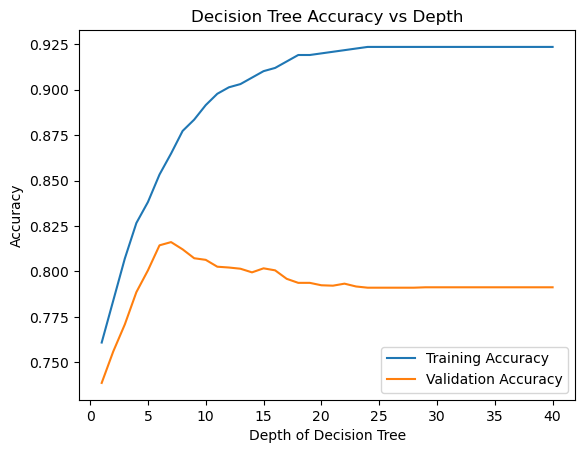

In [13]:
# Plot of validation accuracies as a function of the depth
spam_train, spam_valid, spam_train_labels, spam_valid_labels = train_valid_split(spam_training_data, spam_training_labels, 0.2)

def new_decisionTree_eval(X_train, X_valid, y_train, y_valid, max_depth):
    clf = DecisionTree(max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_pred, valid_pred = clf.predict(X_train), clf.predict(X_valid)
    train_accuracy, valid_accuracy = evaluate_simple(train_pred, y_train), evaluate_simple(valid_pred, y_valid)
    return train_accuracy, valid_accuracy

accuracy = {}
for max_depth in range(1, 41):
    train_acc, valid_acc = new_decisionTree_eval(spam_train, spam_valid, spam_train_labels, spam_valid_labels, max_depth)
    accuracy[max_depth] = (train_acc, valid_acc)

# Output the highest validation accuracy depth
valid_acc_depth_pairs = [(depth, acc[1]) for depth, acc in accuracy.items()]
max_valid_pair = max(valid_acc_depth_pairs, key=lambda item: item[1])
max_depth, max_valid_acc = max_valid_pair
print(f"The highest validation accuracy is {max_valid_acc} at depth {max_depth}.\n")

# Graph
plt.plot(accuracy.keys(), accuracy.values(), label=['Training Accuracy', 'Validation Accuracy'])
plt.title('Decision Tree Accuracy vs Depth')
plt.xlabel('Depth of Decision Tree')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

I found out that the valdiation was high when depth was less than 10. This plot shows the bias-variance tradeoff. Initially, increasing the complexity of the model (with greater depth) reduces bias and improves validation accuracy. However, past a certain point, increasing complexity only adds variance to the model without reducing bias, leading to overfitting and a decrease or stabilization in validation accuracy.

In [14]:
# Titanic Decision Tree Visualization
tit_dT = DecisionTree(max_depth=3, feature_labels=titanic_features)
tit_dT.fit(titanic_training, titanic_training_labels)
print(tit_dT.tree_to_string())

 ('female') < 1.0
   ('pclass') < 2.0
     ('age') < 17.0
      Predict: 1
     ('age') >= 17.0
      Predict: 0
   ('pclass') >= 2.0
     ('age') < 4.0
      Predict: 1
     ('age') >= 4.0
      Predict: 0
 ('female') >= 1.0
   ('pclass') < 3.0
     ('fare') < 31.6833
      Predict: 1
     ('fare') >= 31.6833
      Predict: 1
   ('pclass') >= 3.0
     ('fare') < 23.45
      Predict: 1
     ('fare') >= 23.45
      Predict: 0

